# Covid-19 Tracker for Spain
https://cnecovid.isciii.es/covid19/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os
import boto3
from app_funcs import *

## Data Gathering & Cleaning

Covid Dataset

In [2]:
data = get_data()
data.head()

,province,sex,age,date,cases,hospitalizations,icu,deaths
12720,A,H,0s,2020-01-09,0,0,0,0
12721,A,H,10s,2020-01-09,0,0,0,0
12722,A,H,20s,2020-01-09,0,0,0,0
12723,A,H,30s,2020-01-09,0,0,0,0
12724,A,H,40s,2020-01-09,0,0,0,0


In [3]:
data.tail()

,province,sex,age,date,cases,hospitalizations,icu,deaths
1423045,ZA,NC,50s,2022-06-13,0,0,0,0
1423046,ZA,NC,60s,2022-06-13,0,0,0,0
1423047,ZA,NC,70s,2022-06-13,0,0,0,0
1423048,ZA,NC,80+,2022-06-13,0,0,0,0
1423049,ZA,NC,NC,2022-06-13,0,0,0,0


In [4]:
data, peaks, valleys = get_waves(get_sma7_gby_date,data)
data.head()

,province,sex,age,date,cases,hospitalizations,icu,deaths,wave
12720,A,H,0s,2020-01-09,0,0,0,0,1
12721,A,H,10s,2020-01-09,0,0,0,0,1
12722,A,H,20s,2020-01-09,0,0,0,0,1
12723,A,H,30s,2020-01-09,0,0,0,0,1
12724,A,H,40s,2020-01-09,0,0,0,0,1


In [5]:
plot_data = get_sma7_gby_date(data)

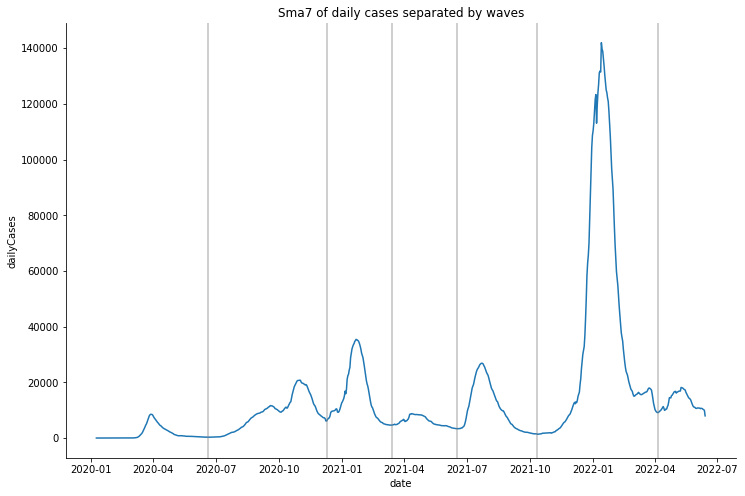

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.lineplot(data=plot_data, x='date', y='dailyCases')
for valley in valleys:
    plt.axvline(valley, color='gray', alpha = 0.5)
sns.despine(top=True, right=True)
ax.set_title('Sma7 of daily cases separated by waves')
plt.savefig('../blog/covid_dash_waves_plot.jpg')

In [9]:
daily_data = data.groupby('date').sum()
daily_data

,cases,hospitalizations,icu,deaths
date,,,,
2020-01-09,1,8,0,0
2020-01-10,1,9,0,0
2020-01-11,0,3,1,0
2020-01-12,1,6,0,0
2020-01-13,0,8,0,0
...,...,...,...,...
2022-06-09,11720,438,16,25
2022-06-10,10253,373,11,19
2022-06-11,3779,282,8,5


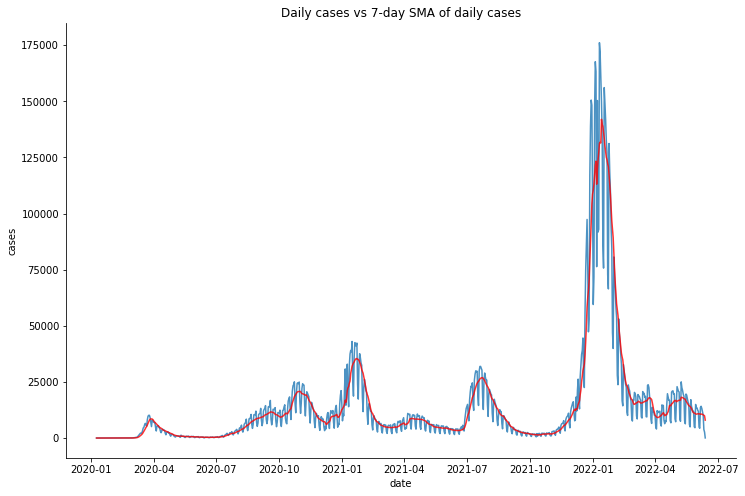

In [21]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.lineplot(data=daily_data, x='date', y='cases', alpha=0.8)
sns.lineplot(data=plot_data, x='date', y='dailyCases', color='r', alpha=0.8)
sns.despine(top=True, right=True)
ax.set_title('Daily cases vs 7-day SMA of daily cases')
plt.savefig('../blog/covid_dash_daily_vs_sma.jpg')

In [4]:
data.tail()

,province,sex,age,date,cases,hospitalizations,icu,deaths,wave
1367395,ZA,NC,50s,2022-05-09,0,0,0,0,6
1367396,ZA,NC,60s,2022-05-09,0,0,0,0,6
1367397,ZA,NC,70s,2022-05-09,0,0,0,0,6
1367398,ZA,NC,80+,2022-05-09,0,0,0,0,6
1367399,ZA,NC,NC,2022-05-09,0,0,0,0,6


Export to .csv

In [5]:
data.to_csv('../data/covid_19_spain.csv', sep=';', index = False)

# Visualization Sections

In [3]:
data = pd.read_csv('../data/covid_19_spain.csv', sep = ';')
pop = pd.read_csv('../data/population_spain_10s.csv')
prov = pd.read_csv('../data/provincias.csv')

In [4]:
ccaa_map = prov.set_index('codigoProvincia').codigoCCAA
data['autonomousCommunity'] = data.province.str.strip().replace(ccaa_map)

In [5]:
data.head()

,province,sex,age,date,cases,hospitalizations,icu,deaths,wave,autonomousCommunity
0,A,H,0s,2020-01-09,0,0,0,0,1,VC
1,A,H,10s,2020-01-09,0,0,0,0,1,VC
2,A,H,20s,2020-01-09,0,0,0,0,1,VC
3,A,H,30s,2020-01-09,0,0,0,0,1,VC
4,A,H,40s,2020-01-09,0,0,0,0,1,VC


### Time Series Visualization

In [6]:
age_series = get_sma7_gby_age_date(data)

In [7]:
fig = px.line(
    age_series, 
    x="date", 
    y="dailyCases", 
    color='age',
    template = 'simple_white',
    title = 'Daily Cases of Covid-19 by Age in Spain, 7-day Simple Moving Average')
fig.show()

### Heatmap + totals

In [8]:
totals_age_wave = data.groupby(['age', 'wave'], as_index = False).sum()
mask = totals_age_wave.age != 'NC'
totals_age_wave = totals_age_wave[mask]
heatmap_age_wave_cases = pd.crosstab(totals_age_wave.wave, totals_age_wave.age, totals_age_wave.cases, aggfunc=sum, normalize = 'index')
totals_wave = totals_age_wave.groupby('wave', as_index=False).sum()

In [9]:
totals_wave

,wave,cases,hospitalizations,icu,deaths
0,1,248181,109501,9347,29482
1,2,1499507,111131,10494,21316
2,3,1469625,106670,11143,26015
3,4,558451,43481,5810,5540
4,5,1217689,45509,4924,6185
5,6,7082206,115382,8187,16407


Text(0.5, 1.0, 'Total Cases by Wave (Thousands)')

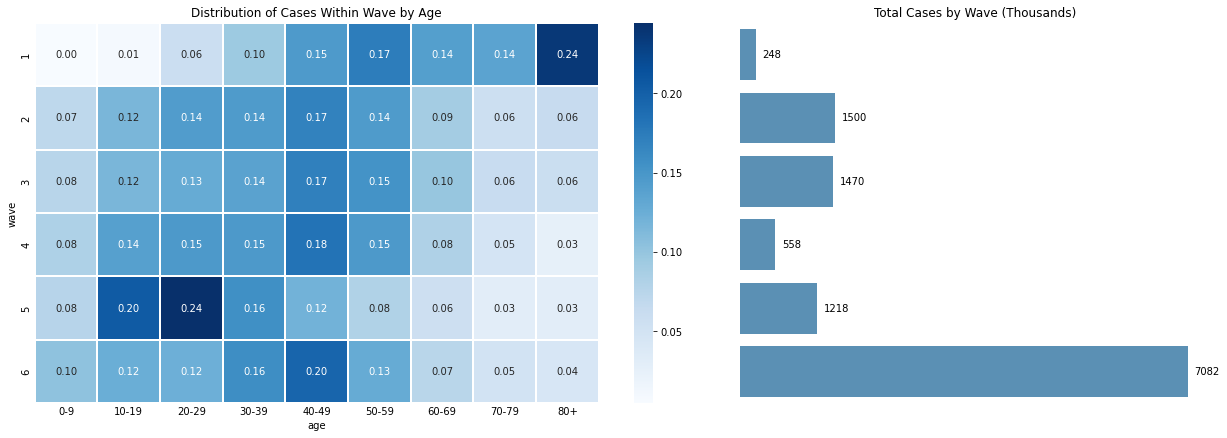

In [153]:
# figure and spacing
size_unit=np.array([1.7*1.77, 1])
fig, ax = plt.subplots(1, 2, figsize=7*size_unit, gridspec_kw={"width_ratios": (.6, .4)})
fig.subplots_adjust(wspace=0, hspace=0)
# heatmap
sns.heatmap(
    data = heatmap_age_wave, 
    annot=True, 
    linewidths=0.1, 
    cmap='Blues', 
    fmt='.2f', 
    ax = ax[0],
    )
# barplot
sns.barplot(
    data = totals_wave/1000, 
    x='cases', 
    y='wave', 
    orient = 'h', 
    color=sns.color_palette()[0], 
    ax=ax[1],
    alpha=0.8,
    )
# despine barplot
sns.despine(fig=fig, ax=ax[1], top=True, bottom=True, left=True, right=True)
# Axes styling
ax[0].tick_params(axis=u'both', which=u'both',length=0)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
ax[1].set(
    ylabel=None,
    xlabel=None,
    yticklabels=[],
    xticklabels=[],
    xticks=[],
    )
# show labels
ax[1].bar_label(
    ax[1].containers[0],
    fmt='%.0f',
    padding=7,
    )
# titles
ax[0].set_title('Distribution of Cases Within Wave by Age')
ax[1].set_title('Total Cases by Wave (Thousands)')

### Within-Age Group distribution by Wave and Totals by age group

In [5]:
get_heatmap_data_age_norm(data, pop, 'cases')

wave,1,2,3,4,5,6
age,,,,,,
0s,0.000289,0.025832,0.027140,0.011252,0.022777,0.178655
10s,0.000466,0.035586,0.034787,0.016019,0.051086,0.181406
20s,0.003010,0.044240,0.038501,0.016863,0.061169,0.178834
30s,0.003962,0.036298,0.033822,0.013759,0.031860,0.187653
40s,0.004658,0.032698,0.032375,0.013117,0.018930,0.178168
50s,0.006135,0.030869,0.031948,0.011674,0.014080,0.128411
60s,0.006453,0.025039,0.026714,0.008480,0.012731,0.096932
70s,0.008631,0.021996,0.023476,0.006726,0.009386,0.091557
80+,0.020754,0.034263,0.031203,0.005064,0.013010,0.110094


In [13]:
totals_age_wave = data.groupby(['age', 'wave'], as_index = False).sum()
mask = totals_age_wave.age != 'NC'
totals_age_wave = totals_age_wave[mask]
a = pd.crosstab(totals_age_wave.wave, totals_age_wave.age, totals_age_wave.cases, aggfunc=sum)
total_pop = pop.groupby('age').population.sum().drop('total')
result = a/total_pop
result = result.T

In [9]:
totals_age = data.groupby('age').sum().drop('NC')

Text(0.5, 1.0, 'Total Population by Age Group')

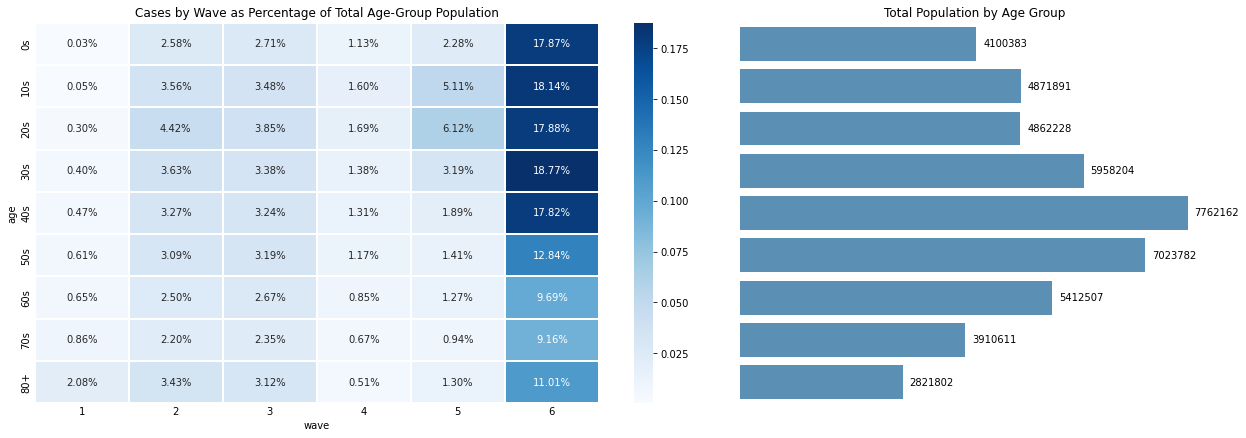

In [48]:
# figure and spacing
size_unit=np.array([1.7*1.77, 1])
fig, ax = plt.subplots(1, 2, figsize=7*size_unit, gridspec_kw={"width_ratios": (.6, .4)})
fig.subplots_adjust(wspace=0, hspace=0)
# heatmap
sns.heatmap(
    data = result, 
    annot=True, 
    linewidths=0.1, 
    cmap='Blues', 
    fmt='.2%', 
    ax = ax[0],
    )
# barplot
sns.barplot(
    data = total_pop.reset_index(), 
    x='population', 
    y='age', 
    orient = 'h', 
    color=sns.color_palette()[0], 
    ax=ax[1],
    alpha=0.8,
    )
# despine barplot
sns.despine(fig=fig, ax=ax[1], top=True, bottom=True, left=True, right=True)
# Axes styling
ax[0].tick_params(axis=u'both', which=u'both',length=0)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
ax[1].set(
    ylabel=None,
    xlabel=None,
    yticklabels=[],
    xticklabels=[],
    xticks=[],
    )
# show labels
ax[1].bar_label(
    ax[1].containers[0],
    fmt='%.0f',
    padding=7,
    )
# titles
ax[0].set_title('Cases by Wave as Percentage of Total Age-Group Population')
ax[1].set_title('Total Population by Age Group')

### Hospitalizations to Cases and Hospitalization as % of total pop

In [23]:
totals_age_wave = data.groupby(['age', 'wave'], as_index = False).sum()
mask = totals_age_wave.age != 'NC'
totals_age_wave = totals_age_wave[mask]
cases = pd.crosstab(totals_age_wave.wave, totals_age_wave.age, totals_age_wave.cases, aggfunc=sum)
hosp = pd.crosstab(totals_age_wave.wave, totals_age_wave.age, totals_age_wave.hospitalizations, aggfunc=sum)
hosp_cases = hosp/cases
hosp_total_pop = hosp/total_pop

In [29]:
def plot_heatmap_ratios(heatmap_data1, heatmap_data2):
    # figure and spacing
    size_unit=np.array([1.7*1.77, 1])
    fig, ax = plt.subplots(1, 2, figsize=7*size_unit, gridspec_kw={"width_ratios": (.5, .5)})
    fig.subplots_adjust(wspace=0, hspace=0)
    # heatmap
    sns.heatmap(
        data = heatmap_data1, 
        annot=True, 
        linewidths=0.1, 
        cmap='Blues', 
        fmt='.2%', 
        ax = ax[0],
        )
    # barplot
    sns.heatmap(
        data = heatmap_data2, 
        annot=True, 
        linewidths=0.1, 
        cmap='Blues', 
        fmt='.2%', 
        ax = ax[1],
        )
    # despine barplot
    # Axes styling
    ax[0].tick_params(axis=u'both', which=u'both',length=0)
    ax[1].tick_params(axis=u'both', which=u'both',length=0)

    # titles
    ax[0].set_title('Hospitalizations by Wave as Percentage of Cases')
    ax[1].set_title('Hospitalizations by Wave as Percentage of Age-Group Population')
    return fig


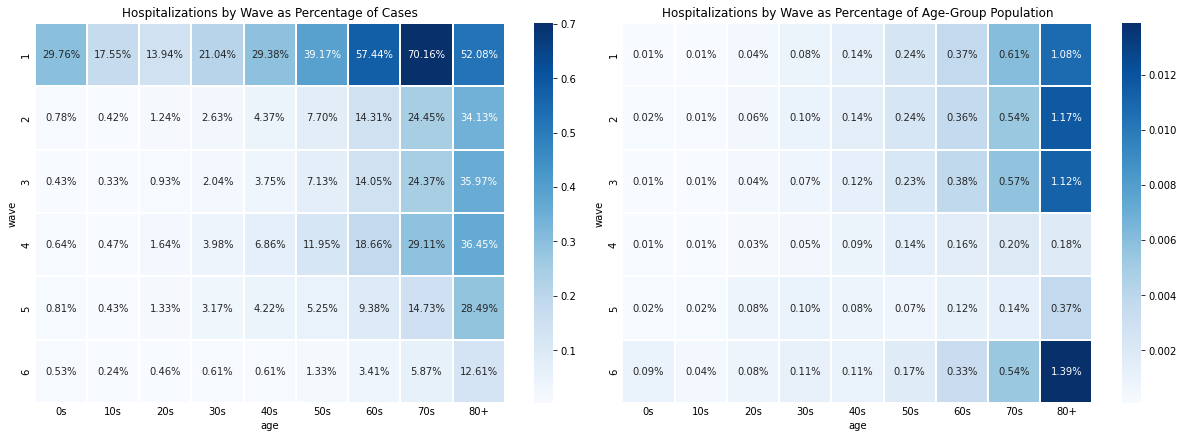

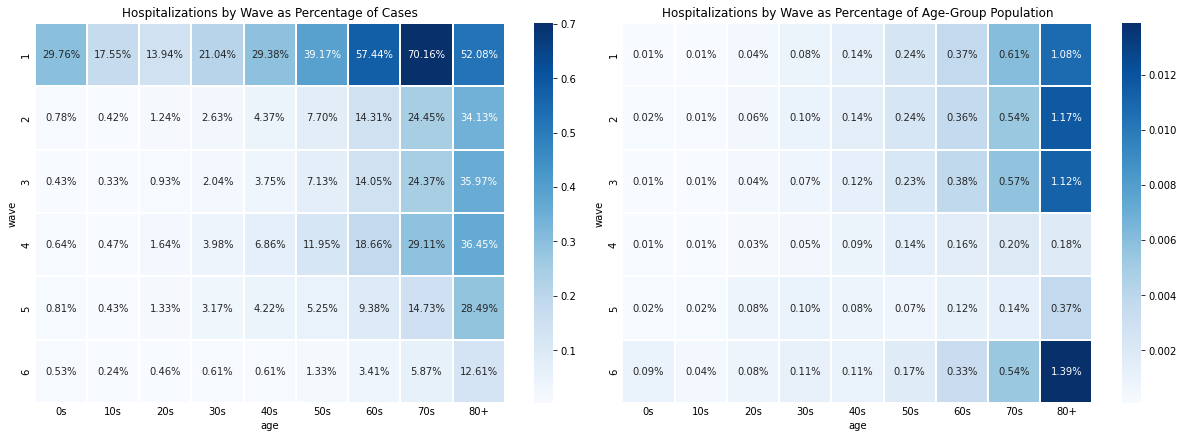

In [30]:
plot_heatmap_ratios(hosp_cases, hosp_total_pop)

### Test

In [2]:
data = pd.read_csv('../data/covid_19_spain.csv', sep = ';')
pop = pd.read_csv('../data/population_spain_10s.csv')
prov = pd.read_csv('../data/provincias.csv')

#### Plotly Lineplot

In [3]:
age_series = get_sma7_gby_age_date(data)
fig = plot_lineplot(age_series, 'dailyCases')
fig.show()

In [4]:
fig.write_image('../blog/covid_dash_plotly_fig.png')

#### Wave Totals Barplot and % of total for each age group

## ARIMA Predictions

In [74]:
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
# assesing data
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

# ignore non invertible arima warnings
import warnings
warnings.filterwarnings('ignore')

### Assess Data

In [75]:
data = pd.read_csv('../data/covid_19_spain.csv', sep = ';')
data.date = pd.to_datetime(data.date)
t_series = data.groupby('date').cases.sum().rolling(7).mean().dropna()
t_series = t_series.asfreq('D')
t_series.shape

(846,)

<AxesSubplot:xlabel='date', ylabel='cases'>

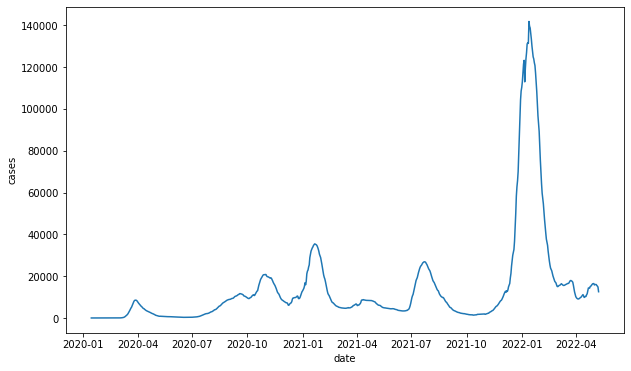

In [76]:
plt.rcParams.update({'figure.figsize': (10,6)})
sns.lineplot(data = t_series)

Decompose

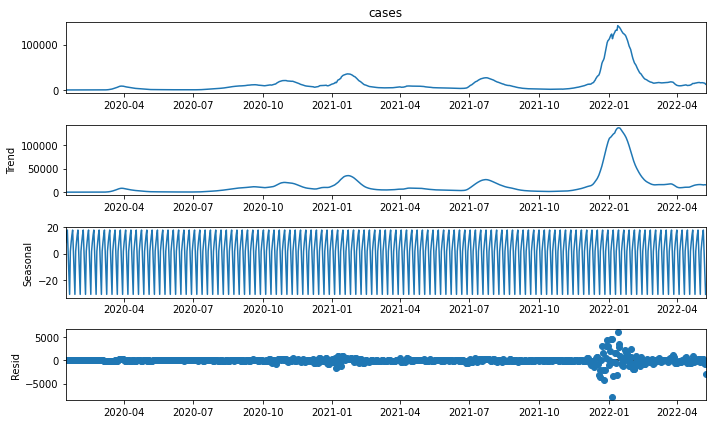

In [77]:
result_add = seasonal_decompose(t_series, model = 'additive', extrapolate_trend = 'freq')
result_add.plot();

- No trend
- Seasonality of +-20

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

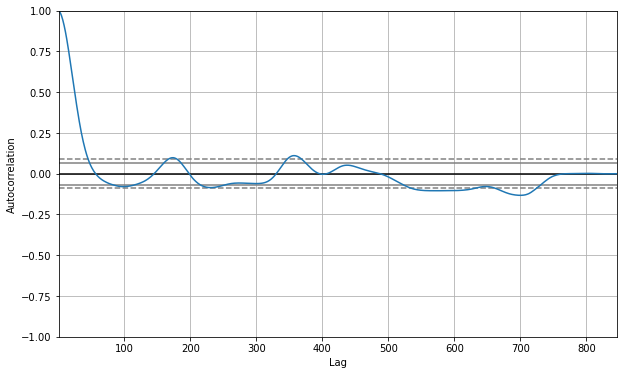

In [78]:
autocorrelation_plot(t_series)

- stabilizes for lag 100

#### Test Sliding windows
- Using sliding window because of how situational to each wave the data is.
- We need to find the model parameter for the previous N days.
- Maybe also tune the forecasting days parameter (set at 7)

30 days window length

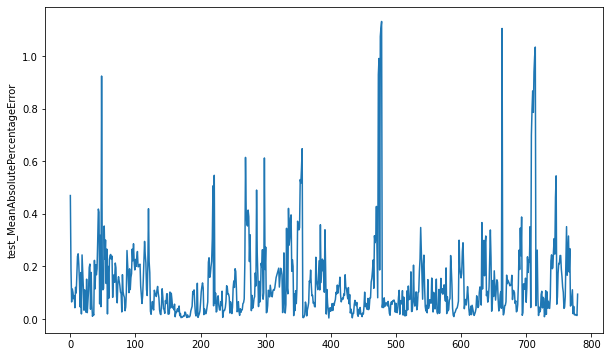

In [84]:
length_days = 30
y = t_series
arima = AutoARIMA(
    start_p = 1,
    start_q = 1,
    start_d = 0
    # max_d = 1,
)
cv = SlidingWindowSplitter(
    step_length=1, 
    fh=list(range(1,8)), 
    window_length=45,
    initial_window=60,
    )
cv_df = evaluate(
    forecaster=arima, 
    y=y, 
    cv=cv, 
    strategy="refit", 
    return_data=True,
    )
sns.lineplot(data=cv_df, x=cv_df.index, y='test_MeanAbsolutePercentageError');

---

45 days window length

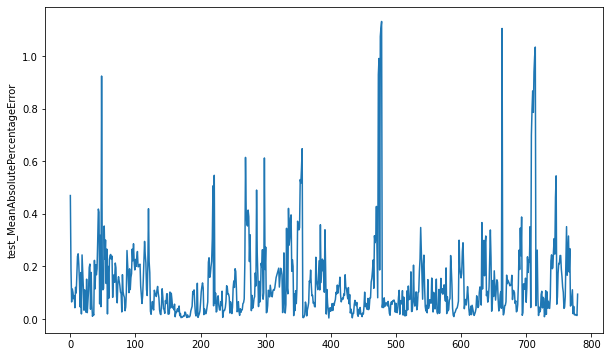

In [85]:
length_days = 45
y = t_series
arima = AutoARIMA(
    start_p = 1,
    start_q = 1,
    start_d = 0
    # max_d = 1,
)
cv = SlidingWindowSplitter(
    step_length=1, 
    fh=list(range(1,8)), 
    window_length=45,
    initial_window=60,
    )
cv_df = evaluate(
    forecaster=arima, 
    y=y, 
    cv=cv, 
    strategy="refit", 
    return_data=True,
    )
sns.lineplot(data=cv_df, x=cv_df.index, y='test_MeanAbsolutePercentageError');

---

60 days window length

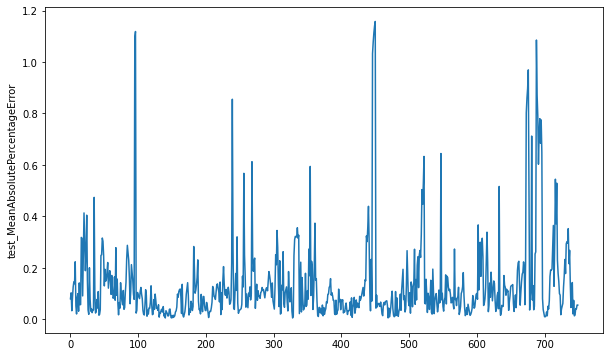

In [86]:
length_days = 60
y = t_series
arima = AutoARIMA(
    start_p = 1,
    start_q = 1,
    start_d = 0
    # max_d = 1,
)
cv = SlidingWindowSplitter(
    step_length=1, 
    fh=list(range(1,8)), 
    window_length=60,
    initial_window=90,
    )
cv_df = evaluate(
    forecaster=arima, 
    y=y, 
    cv=cv, 
    strategy="refit", 
    return_data=True,
    )
sns.lineplot(data=cv_df, x=cv_df.index, y='test_MeanAbsolutePercentageError');